In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import kurtosis, skew
from scipy import stats
import matplotlib.dates as mdates
from scipy.stats import norm
import os


In [2]:
# Super important variables, lets define here
reward_scaling = 1221

## Load files with evaluated training

In [4]:
# we need daily and not monthly returns
def daily_portfolio_returns_from_monthly_weights(daily_returns: pd.DataFrame,
                                                 W_monthly: pd.DataFrame) -> pd.Series:

    R = daily_returns.dropna(how="any").copy()
    month = R.index.to_period("M")

    W = W_monthly.copy()
    W["m"] = W.index.to_period("M")
    W = W.set_index("m").sort_index()

    out = []
    months = sorted(month.unique())
    for m_trade in months:
        if m_trade not in W.index:
            continue

        w = W.loc[m_trade]
        cols = [c for c in w.index if c in R.columns]
        Rt = R.loc[month == m_trade, cols]
        if Rt.empty:
            continue

        out.append(pd.Series(Rt.values @ w[cols].values, index=Rt.index))

    return pd.concat(out).sort_index()


def portfolio_stats_paper_style(returns,
                                periods_per_year=252,
                                rf_annual=0.0,
                                target=0.0,
                                alpha=0.95):

    r = pd.Series(returns).dropna().astype(float).to_numpy()
    if len(r) < 2:
        raise ValueError("need at least 2 observations")
    if not (0.0 < alpha < 1.0):
        raise ValueError("alpha must be in (0,1)")

    mu = float(np.mean(r))
    sigma2 = float(np.var(r, ddof=0))
    sigma = float(np.sqrt(sigma2))

    mu_ann = mu * periods_per_year
    sigma2_ann = sigma2 * periods_per_year
    sigma_ann = float(np.sqrt(sigma2_ann))

    # downside RMS / LPM2
    downside = (r[r < target] - target)
    semivar = 0.0 if downside.size == 0 else float(np.mean(downside**2))
    semidev_ann = float(np.sqrt(semivar * periods_per_year))

    # VaR/CVaR
    q = 1.0 - alpha
    VaR = float(np.quantile(r, q))
    tail = r[r <= VaR]
    CVaR = VaR if tail.size == 0 else float(np.mean(tail))

    # drawdowns
    wealth = np.concatenate([[1.0], np.cumprod(1.0 + r)])
    peak = np.maximum.accumulate(wealth)
    dd = 1.0 - wealth / peak
    pos_dd = dd[dd > 0]
    avg_dd = 0.0 if pos_dd.size == 0 else float(np.mean(pos_dd))

    # excess mean (per-period rf from annual rf)
    rf_per = (1.0 + rf_annual)**(1.0 / periods_per_year) - 1.0
    excess_ann_mean = (mu - rf_per) * periods_per_year

    sharpe = np.nan if sigma_ann == 0 else float(excess_ann_mean / sigma_ann)
    sortino = np.nan if semidev_ann == 0 else float(excess_ann_mean / semidev_ann)

    # tail-adjusted Sharpe (NO annualization of CVaR/mVaR)
    ta_sharpe_cvar = np.nan if CVaR == 0 else float(excess_ann_mean / abs(CVaR))

    # Cornish-Fisher modified VaR
    if sigma == 0:
        skew = 0.0
        exkurt = 0.0
    else:
        xc = r - mu
        m3 = float(np.mean(xc**3))
        m4 = float(np.mean(xc**4))
        skew = m3 / (sigma**3)
        kurt = m4 / (sigma**4)
        exkurt = kurt - 3.0

    z = float(norm.ppf(q))
    z_cf = (z
            + (1/6)  * (z**2 - 1)   * skew
            + (1/24) * (z**3 - 3*z) * exkurt
            - (1/36) * (2*z**3 - 5*z) * (skew**2))

    mVaR = float(mu + sigma * z_cf)
    ta_sharpe_mvar = np.nan if mVaR == 0 else float(excess_ann_mean / abs(mVaR))

    return {
        "Ann. Mean (%)": 100 * mu_ann,
        "Ann. StdDev (%)": 100 * sigma_ann,
        "Ann. SemiDev (%)": 100 * semidev_ann,
        "CVaR 95% (%)": 100 * CVaR,
        "Avg DD (%)": 100 * avg_dd,
        "VaR 95% (%)": 100 * VaR,
        "Sharpe (ann.)": sharpe,
        "Sortino (ann.)": sortino,
        "Tail-Adj Sharpe (CVaR95)": ta_sharpe_cvar,
        "Tail-Adj Sharpe (mVaR95)": ta_sharpe_mvar,
    }


def make_table_for_portfolios(portfolios: dict,
                              periods_per_year=252,
                              rf_annual=0.0,
                              target=0.0,
                              alpha=0.95) -> pd.DataFrame:
    rows = [
        "Ann. Mean (%)",
        "Ann. StdDev (%)",
        "Ann. SemiDev (%)",
        "CVaR 95% (%)",
        "Avg DD (%)",
        "VaR 95% (%)",
        "Sharpe (ann.)",
        "Sortino (ann.)",
        "Tail-Adj Sharpe (CVaR95)",
        "Tail-Adj Sharpe (mVaR95)",
    ]

    out = pd.DataFrame(index=rows)
    for name, r in portfolios.items():
        st = portfolio_stats_paper_style(r, periods_per_year=periods_per_year,
                                         rf_annual=rf_annual, target=target, alpha=alpha)
        out[name] = [st[k] for k in rows]
    return out

def df_to_booktabs_latex(df: pd.DataFrame, caption=None, label=None) -> str:
    latex = df.to_latex(
        escape=True,
        float_format=lambda x: f"{x:.2f}",
        column_format="l" + "r"*df.shape[1],
        bold_rows=False
    )
    # convert to booktabs style
    latex = latex.replace("\\toprule", "\\toprule").replace("\\midrule", "\\midrule").replace("\\bottomrule", "\\bottomrule")
    if caption or label:
        # wrap in table environment if requested
        body = latex
        lines = ["\\begin{table}[!htbp]", "\\centering"]
        if caption:
            lines.append(f"\\caption{{{caption}}}")
        if label:
            lines.append(f"\\label{{{label}}}")
        lines.append(body.strip())
        lines.append("\\end{table}")
        latex = "\n".join(lines)
    return latex

In [5]:
# Create a nested dictionary tau-->seed
tau_levels = [0.1,0.5,0.9]
tau_levels_str = [str(tau).replace('.', '') for tau in tau_levels]
seed_list = [53,274,1234,89] #  [53,274,1234,89]

base_path = 'C:/Users/95att/Desktop/job/First_paper_QAC/Replication extension/Q-A2C-Replication- extension/Q-A2C-Replication-main/Industry/training_outcome'
dfs = {}

for tau_str in tau_levels_str:
    dfs[tau_str] = {}
    for seed in seed_list:
        folder_name = f"20250911_final_test2{seed}_{tau_str}"
        file_path = os.path.join(base_path, folder_name, "test_df_with_shares.csv")

        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            dfs[tau_str][seed] = df
        else:
            print(f" File not found: {file_path}")


In [6]:

# Create a nested dictionary tau-->seed
tau_levels = [0.1,0.5,0.9]
tau_levels_str = [str(tau).replace('.', '') for tau in tau_levels]
seed_list = [53,274,1234,89] #  [53,274,1234,89]
# 20250911_final_weighted_q_spwise_standard_tanh_
base_path = 'C:/Users/95att/Desktop/job/First_paper_QAC/Replication extension/Q-A2C-Replication- extension/Q-A2C-Replication-main/Industry/training_outcome'
dfs_in_sample = {}

for tau_str in tau_levels_str:
    dfs_in_sample[tau_str] = {}
    for seed in seed_list:
        folder_name = f"20250911_final_weighted_q_spwise_standard_tanh_{seed}_{tau_str}"
        file_path = os.path.join(base_path, folder_name, "train_df_with_shares.csv")

        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            dfs_in_sample[tau_str][seed] = df
        else:
            print(f" File not found: {file_path}")


In [7]:
for tau_str, seed_dict in dfs.items():
    for seed, df in seed_dict.items():
        print(f"tau: {tau_str}, seed: {seed}, df shape: {df.shape}")


tau: 01, seed: 53, df shape: (664, 24)
tau: 01, seed: 274, df shape: (664, 24)
tau: 01, seed: 1234, df shape: (664, 24)
tau: 01, seed: 89, df shape: (664, 24)
tau: 05, seed: 53, df shape: (664, 24)
tau: 05, seed: 274, df shape: (664, 24)
tau: 05, seed: 1234, df shape: (664, 24)
tau: 05, seed: 89, df shape: (664, 24)
tau: 09, seed: 53, df shape: (664, 24)
tau: 09, seed: 274, df shape: (664, 24)
tau: 09, seed: 1234, df shape: (664, 24)
tau: 09, seed: 89, df shape: (664, 24)


In [8]:
#  data validity check

def validate_dfs_date_alignment(dfs):
    for tau_str, seed_dict in dfs.items():
        print(f"\nChecking tau = {tau_str}...")
        reference_dates = None
        reference_length = None

        for seed, df in seed_dict.items():
            if 'date' not in df.columns:
                print(f"  Seed {seed}: Missing 'date' column.")
                continue

            df['date'] = pd.to_datetime(df['date'])
            df = df.sort_values('date')  # Ensure consistent order

            date_values = df['date'].values
            num_rows = len(date_values)

            if reference_dates is None:
                reference_dates = date_values
                reference_length = num_rows
                print(f"  Seed {seed}: Set as reference with {num_rows} rows.")
            else:
                if num_rows != reference_length:
                    print(f"  Seed {seed}: Row count mismatch ({num_rows} vs {reference_length})")

                if not np.array_equal(date_values, reference_dates):
                    print(f"  Seed {seed}: Dates do not match reference.")
                else:
                    print(f"  Seed {seed}: Dates match reference.")

    print("\nValidation complete.")


In [9]:
validate_dfs_date_alignment(dfs)



Checking tau = 01...
  Seed 53: Set as reference with 664 rows.
  Seed 274: Dates match reference.
  Seed 1234: Dates match reference.
  Seed 89: Dates match reference.

Checking tau = 05...
  Seed 53: Set as reference with 664 rows.
  Seed 274: Dates match reference.
  Seed 1234: Dates match reference.
  Seed 89: Dates match reference.

Checking tau = 09...
  Seed 53: Set as reference with 664 rows.
  Seed 274: Dates match reference.
  Seed 1234: Dates match reference.
  Seed 89: Dates match reference.

Validation complete.


## Value functions

## What do we expect?
- Each policy is optimized to get the highest discounted value in a specific quantile
- for tau 1 we should get higher mean and lower std for v1
- for tau 7 higher values v7 and lower std
- for higher v-s lower taus are more compressed

## Absolute return distribution

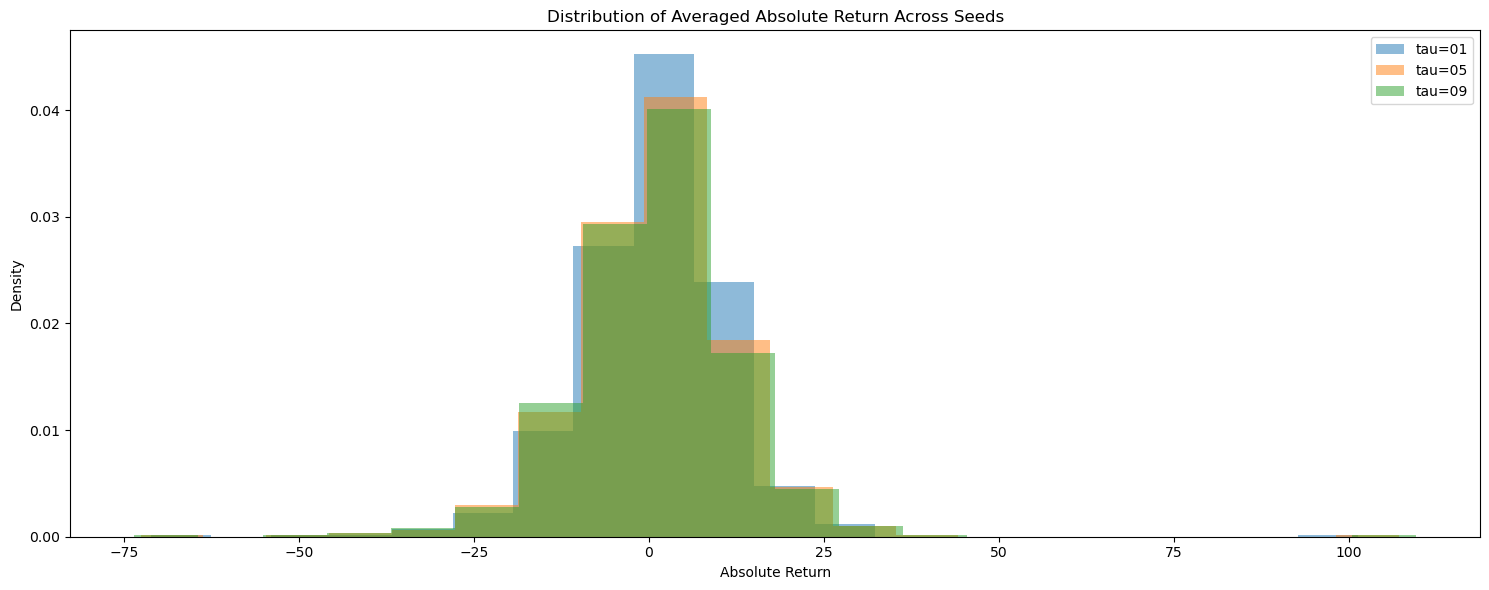

In [13]:
tau_to_abs_returns = {}

for tau_str, seed_dict in dfs.items():
    abs_returns = []
    for seed, df in seed_dict.items():
        if 'absolute_return' in df.columns: # log_growth
            abs_returns.append(df['absolute_return'].values)

    if abs_returns:
        min_len = min(map(len, abs_returns))
        trimmed = [arr[:min_len] for arr in abs_returns]
        avg_abs_return = np.mean(trimmed, axis=0)
        tau_to_abs_returns[tau_str] = avg_abs_return

# Plot histogram of averaged absolute returns
plt.figure(figsize=(15, 6))
for tau_str, avg_abs in tau_to_abs_returns.items():
    plt.hist(avg_abs, bins=20, alpha=0.5, label=f"tau={tau_str}", density=True)

plt.xlabel('Absolute Return')
plt.ylabel('Density')
plt.title('Distribution of Averaged Absolute Return Across Seeds')
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
dfs['01'][53].keys()

Index(['date', 'Durbl', 'Enrgy', 'HiTec', 'Hlth', 'Manuf', 'NoDur', 'Other',
       'Shops', 'Telcm', 'Utils', 'Durbl_share', 'Enrgy_share', 'HiTec_share',
       'Hlth_share', 'Manuf_share', 'NoDur_share', 'Other_share',
       'Shops_share', 'Telcm_share', 'Utils_share', 'absolute_return',
       'cumulative_return', 't_cost_eval'],
      dtype='object')

In [15]:
dfs['01'][53]['t_cost_eval'].head()

0    0.000512
1    0.000093
2    0.000038
3    0.000029
4    0.000021
Name: t_cost_eval, dtype: float64

In [16]:
dfs['01'][53]['t_cost_eval'].sum()

0.016879139443560436

In [17]:
dfs['01'][53].keys()

Index(['date', 'Durbl', 'Enrgy', 'HiTec', 'Hlth', 'Manuf', 'NoDur', 'Other',
       'Shops', 'Telcm', 'Utils', 'Durbl_share', 'Enrgy_share', 'HiTec_share',
       'Hlth_share', 'Manuf_share', 'NoDur_share', 'Other_share',
       'Shops_share', 'Telcm_share', 'Utils_share', 'absolute_return',
       'cumulative_return', 't_cost_eval'],
      dtype='object')

In [18]:



SCALE = 1221.0  # your up-scaling factor

portfolios = {}          # name -> 1D return series (daily)
seed_panel_by_tau = {}   # optional: store the aligned seed panel too

for tau_str in tau_levels_str:
    seed_series = []

    for seed, df in dfs[tau_str].items():
        if "absolute_return" not in df.columns:
            continue

        # scaled back to simple per-day return units (per your note)
        r = df["absolute_return"].astype(float) / SCALE

        if "date" in df.columns:
            idx = pd.to_datetime(df["date"])
        else:
            try:
                idx = pd.to_datetime(df.index)
            except Exception:
                idx = pd.RangeIndex(len(df))

        s = pd.Series(r.to_numpy(), index=idx, name=seed).sort_index()
        seed_series.append(s)

    if not seed_series:
        print(f"No usable seeds for tau_{tau_str}")
        continue

    # Align seeds on the same dates; columns = seeds
    R = pd.concat(seed_series, axis=1).sort_index()

    # Ensemble return series (average across seeds per day)
    # If you want STRICT common dates only, use: R = R.dropna()
    r_ens = R.mean(axis=1)  # skipna=True by default

    portfolios[f"tau_{tau_str}"] = r_ens
    seed_panel_by_tau[tau_str] = R

# Now your paper-style table (one column per tau-policy)
table = make_table_for_portfolios(portfolios, periods_per_year=252, rf_annual=0.0, target=0.0, alpha=0.95)

print(table)
latex = df_to_booktabs_latex(table, caption="Performance by quantile policy (ensemble across seeds)", label="tab:qac_perf")
print(latex)


                             tau_01     tau_05     tau_09
Ann. Mean (%)             18.603982  19.872538  20.351947
Ann. StdDev (%)           14.114451  15.267812  15.741501
Ann. SemiDev (%)          14.384184  15.358167  15.861836
CVaR 95% (%)              -1.910919  -2.056575  -2.122896
Avg DD (%)                 2.588019   2.852668   2.986277
VaR 95% (%)               -1.259286  -1.318782  -1.401128
Sharpe (ann.)              1.318080   1.301597   1.292885
Sortino (ann.)             1.293364   1.293939   1.283076
Tail-Adj Sharpe (CVaR95)   9.735620   9.662929   9.586879
Tail-Adj Sharpe (mVaR95)  18.255181  17.656783  17.393391
\begin{table}[!htbp]
\centering
\caption{Performance by quantile policy (ensemble across seeds)}
\label{tab:qac_perf}
\begin{tabular}{lrrr}
\toprule
 & tau\_01 & tau\_05 & tau\_09 \\
\midrule
Ann. Mean (\%) & 18.60 & 19.87 & 20.35 \\
Ann. StdDev (\%) & 14.11 & 15.27 & 15.74 \\
Ann. SemiDev (\%) & 14.38 & 15.36 & 15.86 \\
CVaR 95\% (\%) & -1.91 & -2.06 & -2.12 

In [19]:
# Add together the in and out of sample data

SCALE = 1221.0

portfolios_combined = {}
seed_panel_combined_by_tau = {}

for tau_str in tau_levels_str:
    seed_series_combined = []
    
    for seed in seed_list:
        # Get in-sample data
        if tau_str in dfs_in_sample and seed in dfs_in_sample[tau_str]:
            df_in = dfs_in_sample[tau_str][seed]
            if "absolute_return" in df_in.columns:
                r_in = df_in["absolute_return"].astype(float) / SCALE
                if "date" in df_in.columns:
                    idx_in = pd.to_datetime(df_in["date"])
                else:
                    idx_in = pd.RangeIndex(len(df_in))
                s_in = pd.Series(r_in.to_numpy(), index=idx_in).sort_index()
            else:
                s_in = pd.Series(dtype=float)
        else:
            s_in = pd.Series(dtype=float)
        
        # Get out-of-sample data
        if tau_str in dfs and seed in dfs[tau_str]:
            df_out = dfs[tau_str][seed]
            if "absolute_return" in df_out.columns:
                r_out = df_out["absolute_return"].astype(float) / SCALE
                if "date" in df_out.columns:
                    idx_out = pd.to_datetime(df_out["date"])
                else:
                    idx_out = pd.RangeIndex(len(df_out))
                s_out = pd.Series(r_out.to_numpy(), index=idx_out).sort_index()
            else:
                s_out = pd.Series(dtype=float)
        else:
            s_out = pd.Series(dtype=float)
        
        # Concatenate in-sample and out-of-sample
        s_combined = pd.concat([s_in, s_out]).sort_index()
        s_combined.name = seed
        
        if len(s_combined) > 0:
            seed_series_combined.append(s_combined)
    
    if not seed_series_combined:
        print(f"No usable seeds for tau_{tau_str} (combined)")
        continue
    
    # Align seeds on the same dates
    R_combined = pd.concat(seed_series_combined, axis=1).sort_index()
    
    # Ensemble return series (average across seeds per day)
    r_ens_combined = R_combined.mean(axis=1)
    
    portfolios_combined[f"tau_{tau_str}"] = r_ens_combined
    seed_panel_combined_by_tau[tau_str] = R_combined

# Generate performance table for combined in-sample + out-of-sample data
table = make_table_for_portfolios(portfolios_combined, periods_per_year=252, rf_annual=0.0, target=0.0, alpha=0.95)

print(table)
latex = df_to_booktabs_latex(table, caption="Performance by quantile policy (in-sample + out-of-sample combined)", label="tab:qac_perf_combined")
print(latex)

                             tau_01     tau_05     tau_09
Ann. Mean (%)             16.822630  18.066120  18.538980
Ann. StdDev (%)           16.523873  17.232658  17.489398
Ann. SemiDev (%)          17.948509  18.522985  18.796961
CVaR 95% (%)              -2.488566  -2.587976  -2.633273
Avg DD (%)                 3.092140   3.252992   3.332512
VaR 95% (%)               -1.383828  -1.470745  -1.485557
Sharpe (ann.)              1.018080   1.048365   1.060012
Sortino (ann.)             0.937272   0.975335   0.986275
Tail-Adj Sharpe (CVaR95)   6.759969   6.980790   7.040281
Tail-Adj Sharpe (mVaR95)  12.416082  12.452600  12.410314
\begin{table}[!htbp]
\centering
\caption{Performance by quantile policy (in-sample + out-of-sample combined)}
\label{tab:qac_perf_combined}
\begin{tabular}{lrrr}
\toprule
 & tau\_01 & tau\_05 & tau\_09 \\
\midrule
Ann. Mean (\%) & 16.82 & 18.07 & 18.54 \\
Ann. StdDev (\%) & 16.52 & 17.23 & 17.49 \\
Ann. SemiDev (\%) & 17.95 & 18.52 & 18.80 \\
CVaR 95\% (\%) & 

In [20]:
s_out.tail()

date
2025-11-20    0.008824
2025-11-21    0.013055
2025-11-24    0.007483
2025-11-25    0.008446
2025-11-26    0.006183
dtype: float64

In [21]:
R

,53,274,1234,89
date,,,,
2023-04-06,0.004666,0.002923,0.003005,0.000955
2023-04-10,0.002855,0.003216,0.002209,0.000191
2023-04-11,-0.012531,-0.008983,-0.008306,-0.003610
2023-04-12,0.013452,0.014066,0.012096,0.009690
2023-04-13,-0.003781,-0.002278,-0.003618,-0.005075
...,...,...,...,...
2025-11-20,0.011057,0.011145,0.008920,0.008824
2025-11-21,0.010808,0.017718,0.014339,0.013055
2025-11-24,0.012214,0.012986,0.010494,0.007483


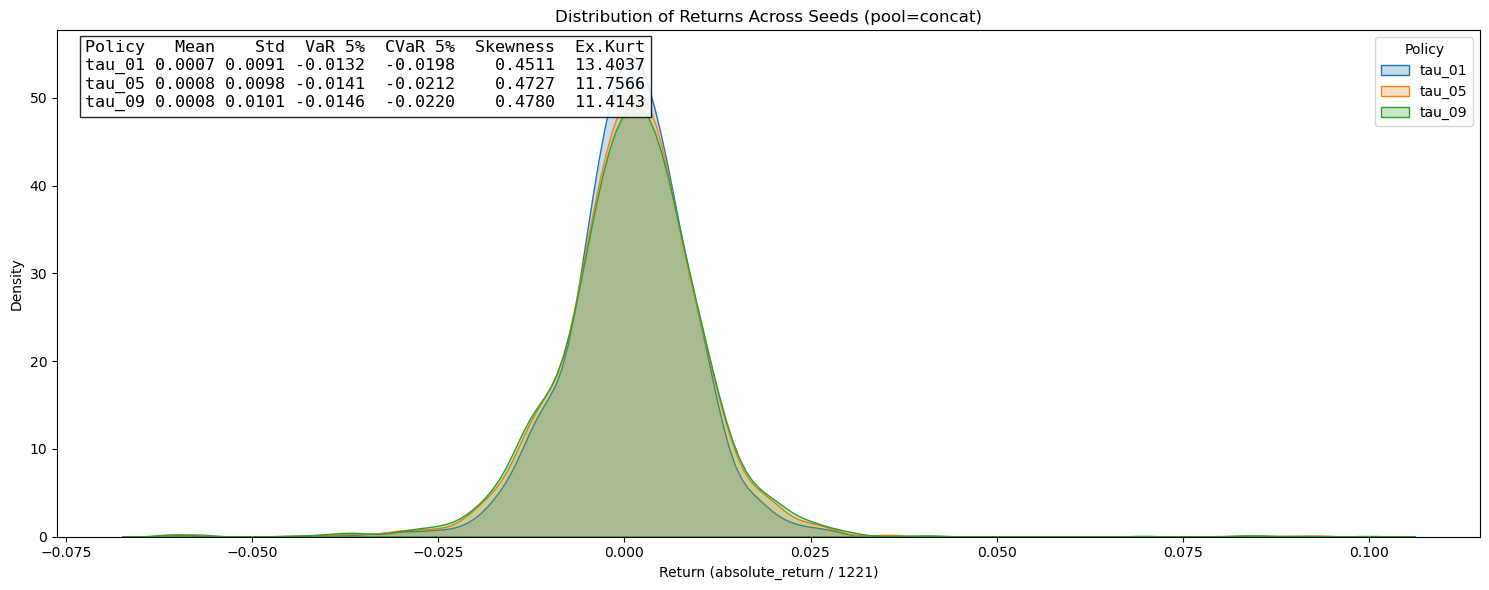

In [22]:

SCALE = 1221.0
POOL_MODE = "concat"      # "concat" or "equal_seed"
ALPHA = 0.95              # for VaR/CVaR

plt.figure(figsize=(15, 6))
stats_list = []

for tau_str in tau_levels_str:
    seed_arrays = []

    for seed, df in dfs[tau_str].items():
        if "absolute_return" not in df.columns:
            continue
        x = df["absolute_return"].astype(float).to_numpy() / SCALE
        x = x[np.isfinite(x)]
        if x.size > 0:
            seed_arrays.append(x)

    if not seed_arrays:
        continue

    if POOL_MODE == "concat":
        combined = np.concatenate(seed_arrays)

    elif POOL_MODE == "equal_seed":
        # equal-weight seeds: sample same number from each seed (min length)
        m = min(len(x) for x in seed_arrays)
        combined = np.concatenate([x[:m] for x in seed_arrays])

    else:
        raise ValueError("POOL_MODE must be 'concat' or 'equal_seed'")

    # KDE
    sns.kdeplot(combined, label=f"tau_{tau_str}", fill=True)

    # Stats
    mean_val = float(np.mean(combined))
    std_val  = float(np.std(combined, ddof=0))
    skew_val = float(skew(combined, bias=False))
    kurt_val = float(kurtosis(combined, fisher=True, bias=False))  # excess kurtosis

    q = 1.0 - ALPHA
    var_val = float(np.quantile(combined, q))
    tail = combined[combined <= var_val]
    cvar_val = float(np.mean(tail)) if tail.size > 0 else var_val

    stats_list.append([f"tau_{tau_str}", mean_val, std_val, var_val, cvar_val, skew_val, kurt_val])

plt.xlabel("Return (absolute_return / 1221)")
plt.ylabel("Density")
plt.title(f"Distribution of Returns Across Seeds (pool={POOL_MODE})")
plt.legend(title="Policy")

# Table box
stats_df = pd.DataFrame(
    stats_list,
    columns=["Policy", "Mean", "Std", "VaR 5%", "CVaR 5%", "Skewness", "Ex.Kurt"]
)

stats_text = stats_df.to_string(index=False, float_format=lambda x: f"{x:.4f}")

ax = plt.gca()
ax.text(
    0.02, 0.98, stats_text,
    fontsize=12, family="monospace",
    transform=ax.transAxes,
    va="top",
    bbox=dict(facecolor="white", alpha=0.85, edgecolor="black")
)

plt.tight_layout()
plt.savefig("return_distribution_stats_stepwise.png", dpi=300, bbox_inches="tight")
plt.show()


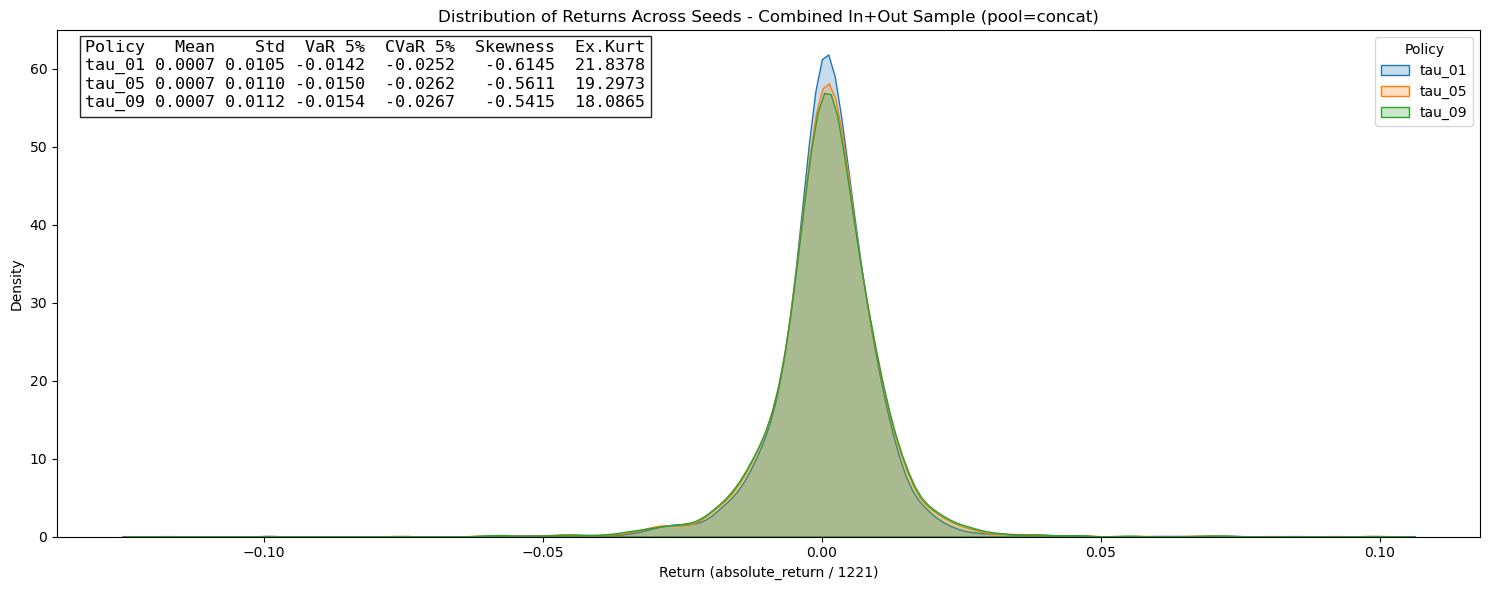

In [23]:
# Merged kde - Combined In-Sample + Out-of-Sample

SCALE = 1221.0
POOL_MODE = "concat"      # "concat" or "equal_seed"
ALPHA = 0.95              # for VaR/CVaR

plt.figure(figsize=(15, 6))
stats_list = []

for tau_str in tau_levels_str:
    seed_arrays = []
    
    for seed in seed_list:
        # Combine in-sample and out-of-sample data
        combined_returns = []
        
        # Get in-sample data
        if tau_str in dfs_in_sample and seed in dfs_in_sample[tau_str]:
            df_in = dfs_in_sample[tau_str][seed]
            if "absolute_return" in df_in.columns:
                r_in = df_in["absolute_return"].astype(float).to_numpy() / SCALE
                r_in = r_in[np.isfinite(r_in)]
                if r_in.size > 0:
                    combined_returns.append(r_in)
        
        # Get out-of-sample data
        if tau_str in dfs and seed in dfs[tau_str]:
            df_out = dfs[tau_str][seed]
            if "absolute_return" in df_out.columns:
                r_out = df_out["absolute_return"].astype(float).to_numpy() / SCALE
                r_out = r_out[np.isfinite(r_out)]
                if r_out.size > 0:
                    combined_returns.append(r_out)
        
        # Concatenate in-sample and out-of-sample for this seed
        if combined_returns:
            x = np.concatenate(combined_returns)
            if x.size > 0:
                seed_arrays.append(x)

    if not seed_arrays:
        continue

    if POOL_MODE == "concat":
        combined = np.concatenate(seed_arrays)

    elif POOL_MODE == "equal_seed":
        # equal-weight seeds: sample same number from each seed (min length)
        m = min(len(x) for x in seed_arrays)
        combined = np.concatenate([x[:m] for x in seed_arrays])

    else:
        raise ValueError("POOL_MODE must be 'concat' or 'equal_seed'")

    # KDE
    sns.kdeplot(combined, label=f"tau_{tau_str}", fill=True)

    # Stats
    mean_val = float(np.mean(combined))
    std_val  = float(np.std(combined, ddof=0))
    skew_val = float(skew(combined, bias=False))
    kurt_val = float(kurtosis(combined, fisher=True, bias=False))  # excess kurtosis

    q = 1.0 - ALPHA
    var_val = float(np.quantile(combined, q))
    tail = combined[combined <= var_val]
    cvar_val = float(np.mean(tail)) if tail.size > 0 else var_val

    stats_list.append([f"tau_{tau_str}", mean_val, std_val, var_val, cvar_val, skew_val, kurt_val])

plt.xlabel("Return (absolute_return / 1221)")
plt.ylabel("Density")
plt.title(f"Distribution of Returns Across Seeds - Combined In+Out Sample (pool={POOL_MODE})")
plt.legend(title="Policy")

# Table box
stats_df = pd.DataFrame(
    stats_list,
    columns=["Policy", "Mean", "Std", "VaR 5%", "CVaR 5%", "Skewness", "Ex.Kurt"]
)

stats_text = stats_df.to_string(index=False, float_format=lambda x: f"{x:.4f}")

ax = plt.gca()
ax.text(
    0.02, 0.98, stats_text,
    fontsize=12, family="monospace",
    transform=ax.transAxes,
    va="top",
    bbox=dict(facecolor="white", alpha=0.85, edgecolor="black")
)

plt.tight_layout()
plt.savefig("return_distribution_stats_combined_stepwise.png", dpi=300, bbox_inches="tight")
plt.show()

## Cumulative reward comparison

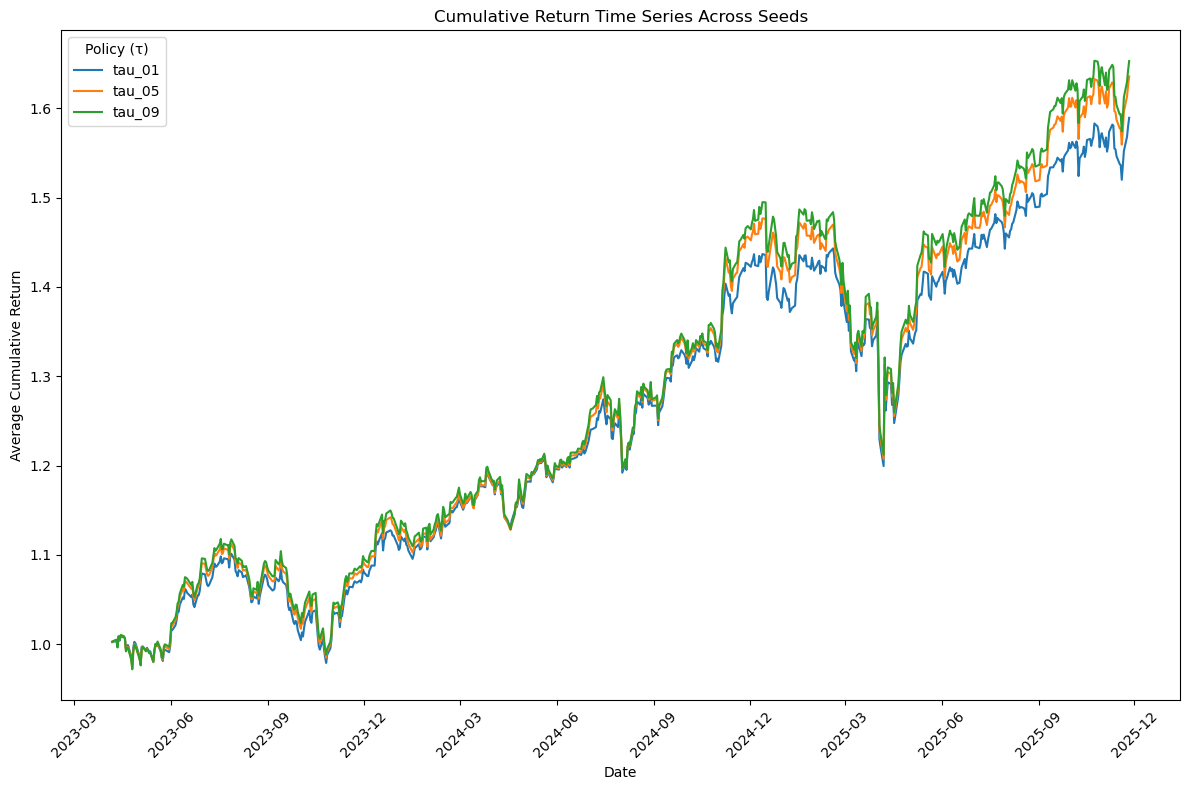

In [25]:


plt.figure(figsize=(12, 8))
ax = plt.gca()

for tau_str in dfs:
    cum_returns_list = []
    date_index = None

    for seed, df in dfs[tau_str].items():
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date')
        if date_index is None:
            date_index = df['date'].values
        cum_returns_list.append(df['cumulative_return'].values)

    avg_cum_return = np.mean(np.stack(cum_returns_list), axis=0)
    plt.plot(date_index, avg_cum_return, label=f'tau_{tau_str}')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))     
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))    

plt.xlabel('Date')
plt.ylabel('Average Cumulative Return')
plt.title('Cumulative Return Time Series Across Seeds')
plt.legend(title='Policy (τ)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("avg_cumulative_returns_stepwise.png", dpi=300, bbox_inches='tight')
plt.show()


In [26]:


# Get dates from one of the dataframes (they all have the same dates)
first_tau = list(dfs.keys())[0]
first_seed = list(dfs[first_tau].keys())[0]
dates_df = dfs[first_tau][first_seed][['date']].copy()
dates_df['date'] = pd.to_datetime(dates_df['date'])
dates_df = dates_df.sort_values('date')

# Save to CSV
dates_df.to_csv('cumulative_reward_dates.csv', index=False)
print(f"Total number of dates: {len(dates_df)}")
print(f"Date range: {dates_df['date'].min()} to {dates_df['date'].max()}")

Total number of dates: 664
Date range: 2023-04-06 00:00:00 to 2025-11-26 00:00:00


In [27]:
df['date'].tail()

659   2025-11-20
660   2025-11-21
661   2025-11-24
662   2025-11-25
663   2025-11-26
Name: date, dtype: datetime64[ns]

In [28]:
df['date']


0     2023-04-06
1     2023-04-10
2     2023-04-11
3     2023-04-12
4     2023-04-13
         ...    
659   2025-11-20
660   2025-11-21
661   2025-11-24
662   2025-11-25
663   2025-11-26
Name: date, Length: 664, dtype: datetime64[ns]

In [29]:
import numpy as np

# Suppose we have two next regimes k' (bull, bear) with probabilities q=[0.6, 0.4]
# And we draw 5 shocks per regime for some loss values

q = np.array([0.6, 0.4])
n_scen = 5

losses_bull = np.array([1.0, 1.1, 0.9, 1.2, 1.05])  # 5 shocks for bull
losses_bear = np.array([3.0, 3.1, 2.9, 3.2, 3.05])  # 5 shocks for bear

losses = np.concatenate([losses_bull, losses_bear])
q_per_sample = np.array([q[0]]*n_scen + [q[1]]*n_scen)

weighted_sum = np.sum(q_per_sample * losses)
normalizer = np.sum(q_per_sample)
expected_value_code = weighted_sum / normalizer

mean_bull = np.mean(losses_bull)
mean_bear = np.mean(losses_bear)
expected_value_theory = q[0]*mean_bull + q[1]*mean_bear

expected_value_code, expected_value_theory


(1.85, 1.85)

In [30]:
normalizer

5.000000000000001

# Average plot for shares

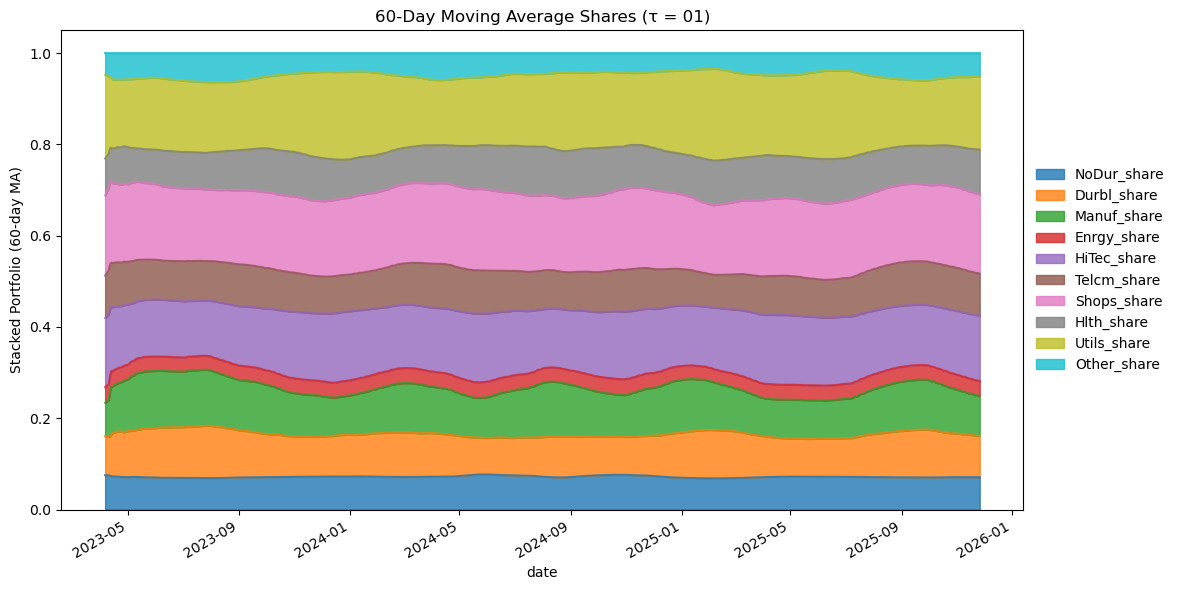

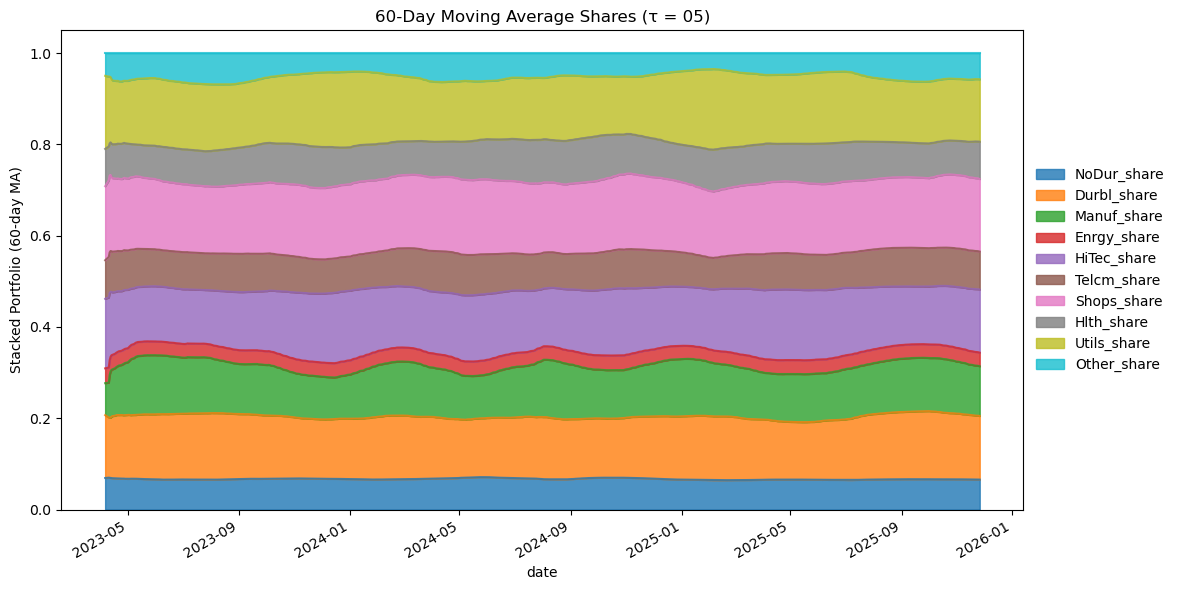

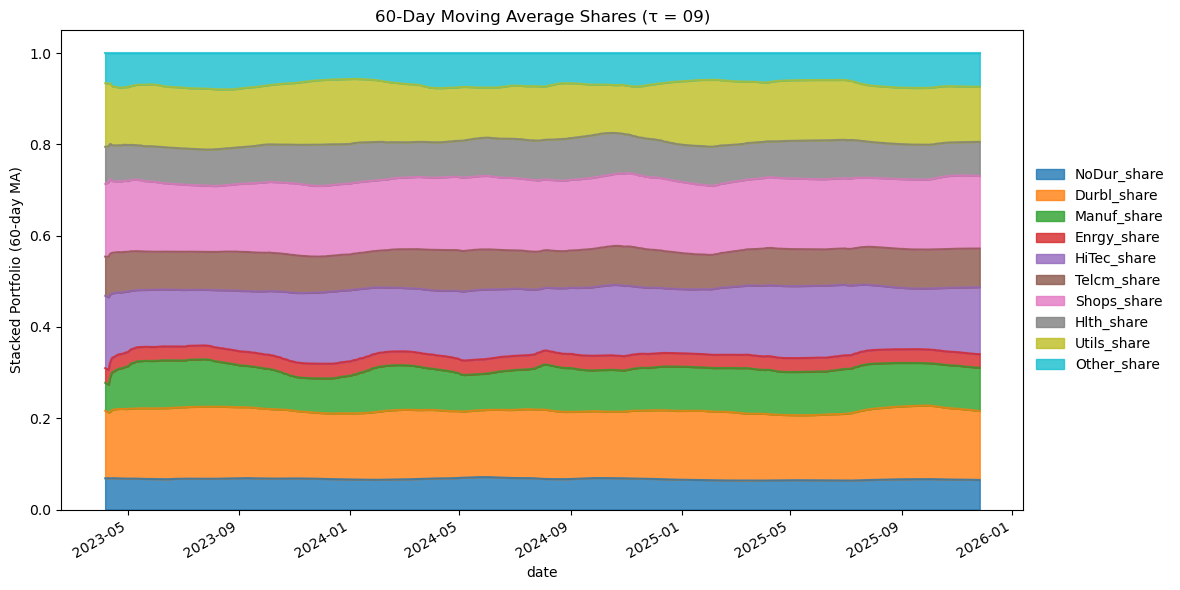

In [32]:
def _plot_smoothed_shares(df, tau_str):
    share_cols = [c for c in df.columns if c.endswith('_share')]
    df_shares = df[['date'] + share_cols].copy()
    df_shares['date'] = pd.to_datetime(df_shares['date'])
    df_shares.set_index('date', inplace=True)

    df_ma = df_shares.rolling(window=60, min_periods=1).mean()

    ax = df_ma.plot(kind='area', stacked=True, figsize=(14, 6), alpha=0.8)
    ax.set_ylabel('Stacked Portfolio (60-day MA)')
    ax.set_title(f'60-Day Moving Average Shares (τ = {tau_str})')

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    filename = f"smoothed_shares_tau_stepwise_{tau_str}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
'''
share_columns = [
'SMALL LoBM', 'ME1 BM2', 'ME1 BM3', 'ME1 BM4',
       'SMALL HiBM', 'ME2 BM1', 'ME2 BM2', 'ME2 BM3', 'ME2 BM4', 'ME2 BM5',
       'ME3 BM1', 'ME3 BM2', 'ME3 BM3', 'ME3 BM4', 'ME3 BM5', 'ME4 BM1',
       'ME4 BM2', 'ME4 BM3', 'ME4 BM4', 'ME4 BM5', 'BIG LoBM', 'ME5 BM2',
       'ME5 BM3', 'ME5 BM4', 'BIG HiBM'
]
'''
share_columns = ['NoDur_share', 'Durbl_share', 'Manuf_share', 'Enrgy_share', 'HiTec_share', 'Telcm_share', 'Shops_share', 'Hlth_share',
       'Utils_share', 'Other_share']


for tau_str in dfs:
    all_seed_dfs = []

    for seed, df in dfs[tau_str].items():
        df = df.copy()
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date')
        df = df[['date'] + share_columns]
        all_seed_dfs.append(df)

    combined_df = pd.concat(all_seed_dfs)

    avg_df = combined_df.groupby('date')[share_columns].mean().reset_index()

    _plot_smoothed_shares(avg_df, tau_str)


In [33]:
share_cols = [c for c in all_seed_dfs[0].columns if c.endswith('_share')]
share_cols

['NoDur_share',
 'Durbl_share',
 'Manuf_share',
 'Enrgy_share',
 'HiTec_share',
 'Telcm_share',
 'Shops_share',
 'Hlth_share',
 'Utils_share',
 'Other_share']

In [34]:
all_seed_dfs

[          date  NoDur_share  Durbl_share  Manuf_share  Enrgy_share  \
 0   2023-04-06     0.037192     0.195327     0.034094     0.034005   
 1   2023-04-10     0.038735     0.168103     0.037138     0.037075   
 2   2023-04-11     0.039522     0.189114     0.036238     0.036125   
 3   2023-04-12     0.038571     0.186055     0.036628     0.036442   
 4   2023-04-13     0.039184     0.200612     0.035861     0.035584   
 ..         ...          ...          ...          ...          ...   
 659 2025-11-20     0.033458     0.199651     0.032085     0.032085   
 660 2025-11-21     0.033711     0.206299     0.032409     0.032409   
 661 2025-11-24     0.034438     0.218013     0.032503     0.032503   
 662 2025-11-25     0.034870     0.219511     0.033282     0.033282   
 663 2025-11-26     0.034296     0.222014     0.032486     0.032487   
 
      HiTec_share  Telcm_share  Shops_share  Hlth_share  Utils_share  \
 0       0.034005     0.250632     0.250106    0.058533     0.072119   
 1

In [35]:
# SPY500 

C:\Users\95att\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Regime counts:
regime
bear     783
bull    1728
Name: count, dtype: int64


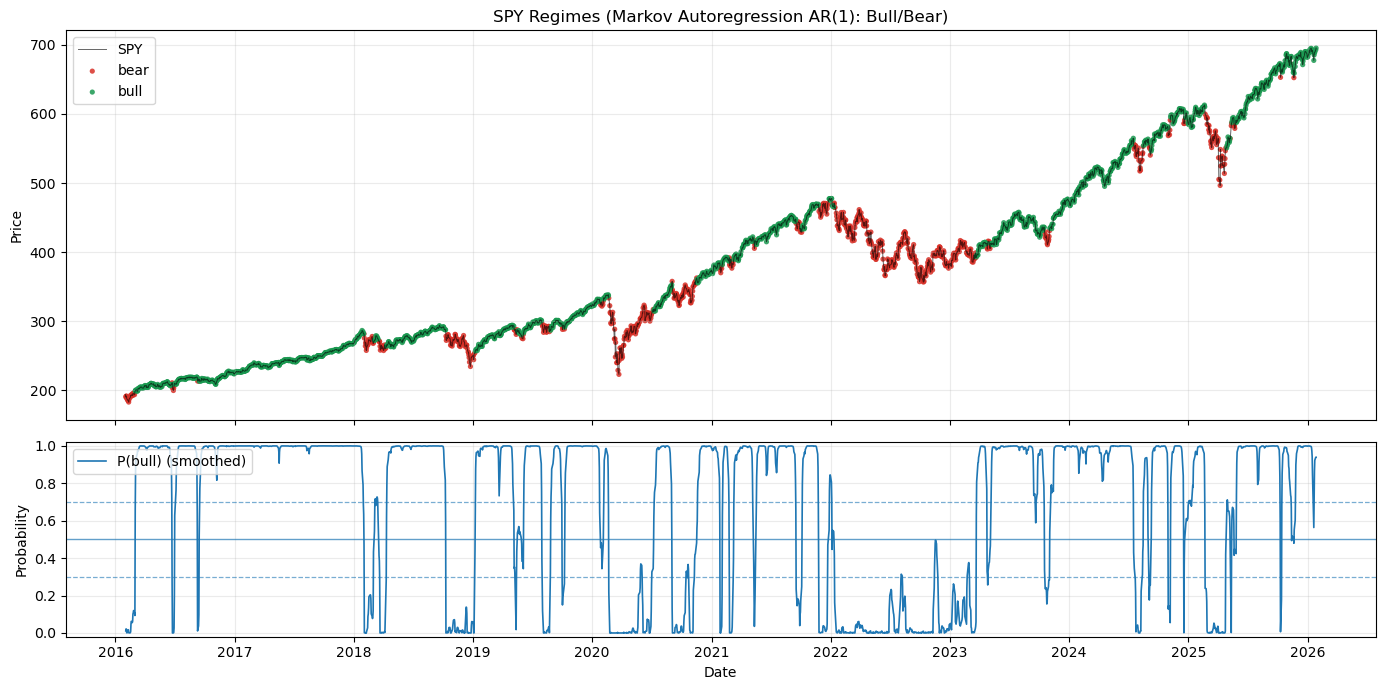

In [36]:
# SPY500 regime detection (bull / bear) with Markov Autoregression (AR(1))


from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression

# -----------------------
# source: https://www.nasdaq.com/market-activity/etf/spy/historical?page=252&rows_per_page=10&timeline=y10
# -----------------------
spy_path = r"C:\Users\95att\Downloads\HistoricalData_1769645338732.csv"
spy = pd.read_csv(spy_path)

# Detect date and close columns
date_col = next((c for c in spy.columns if "date" in c.lower()), None)
close_candidates = [c for c in spy.columns if any(k in c.lower() for k in ["close", "last", "price"])]
close_col = close_candidates[0] if close_candidates else None

if date_col is None or close_col is None:
    raise ValueError(f"Could not detect date/close columns. Columns: {list(spy.columns)}")

spy[date_col] = pd.to_datetime(spy[date_col])
spy = spy.sort_values(date_col)

# Clean price
price = (
    spy[close_col]
    .astype(str)
    .str.replace(r"[$,]", "", regex=True)
    .astype(float)
)

spy = spy.assign(price=price).set_index(date_col)

# Log returns
spy["ret"] = np.log(spy["price"]).diff()
spy = spy.dropna(subset=["ret"]).copy()


k_regimes = 2
order = 1

model = MarkovAutoregression(
    spy["ret"],
    k_regimes=k_regimes,
    order=order,
    trend="c",
    switching_variance=True,
    switching_ar=True,   # allow AR coefficient to differ by regime
)

res = model.fit(
    disp=False,
    em_iter=30,          # EM warm-start iterations
    search_reps=30,      # multiple random starts (helps avoid local maxima)
    maxiter=200,         # optimizer iterations
    method="bfgs",
)

# -----------------------
# 3) Extract smoothed probabilities + label regimes (bear/bull)
# -----------------------
probs = res.smoothed_marginal_probabilities  # columns are regime indices (0..k-1)
state_hard = probs.idxmax(axis=1)

# Label regimes by mean return (low=Bear, high=Bull) using hard state assignment
state_means = spy.groupby(state_hard)["ret"].mean().sort_values()
ordered_states = list(state_means.index)

label_map = {ordered_states[0]: "bear", ordered_states[1]: "bull"}
spy["regime"] = state_hard.map(label_map)

# Bull probability is probability of the higher-mean state
bull_state = ordered_states[1]
spy["p_bull"] = probs[bull_state]

print("Regime counts:")
print(spy["regime"].value_counts().sort_index())

# -----------------------
# 4) Better plotting: price + colored dots + bull probability subplot
# -----------------------
colors = {"bear": "#d73027", "bull": "#1a9850"}

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(14, 7), sharex=True, gridspec_kw={"height_ratios": [2, 1]}
)

# Price line (thin)
ax1.plot(spy.index, spy["price"], color="black", linewidth=0.7, alpha=0.6, label="SPY")

# Colored dots by regime (more visible)
for regime, grp in spy.groupby("regime"):
    ax1.scatter(
        grp.index, grp["price"],
        s=14,  # dot size: increase for more visibility
        color=colors.get(regime, "gray"),
        alpha=0.85,
        label=regime,
        edgecolors="none",
    )

ax1.set_title("SPY Regimes (Markov Autoregression AR(1): Bull/Bear)")
ax1.set_ylabel("Price")
ax1.legend(loc="upper left")
ax1.grid(True, alpha=0.25)

# Probability plot
ax2.plot(spy.index, spy["p_bull"], linewidth=1.2, label="P(bull) (smoothed)")
ax2.axhline(0.5, linewidth=1.0, alpha=0.7)
ax2.axhline(0.7, linestyle="--", linewidth=0.9, alpha=0.6)
ax2.axhline(0.3, linestyle="--", linewidth=0.9, alpha=0.6)
ax2.set_ylabel("Probability")
ax2.set_xlabel("Date")
ax2.set_ylim(-0.02, 1.02)
ax2.legend(loc="upper left")
ax2.grid(True, alpha=0.25)

plt.tight_layout()
plt.show()

       corr_with_spy
tic                 
HiTec       0.927930
Manuf       0.912767
Other       0.911269
Shops       0.887634
Hlth        0.798981
Telcm       0.744607
NoDur       0.744547
Durbl       0.668917
Utils       0.632901
Enrgy       0.608818


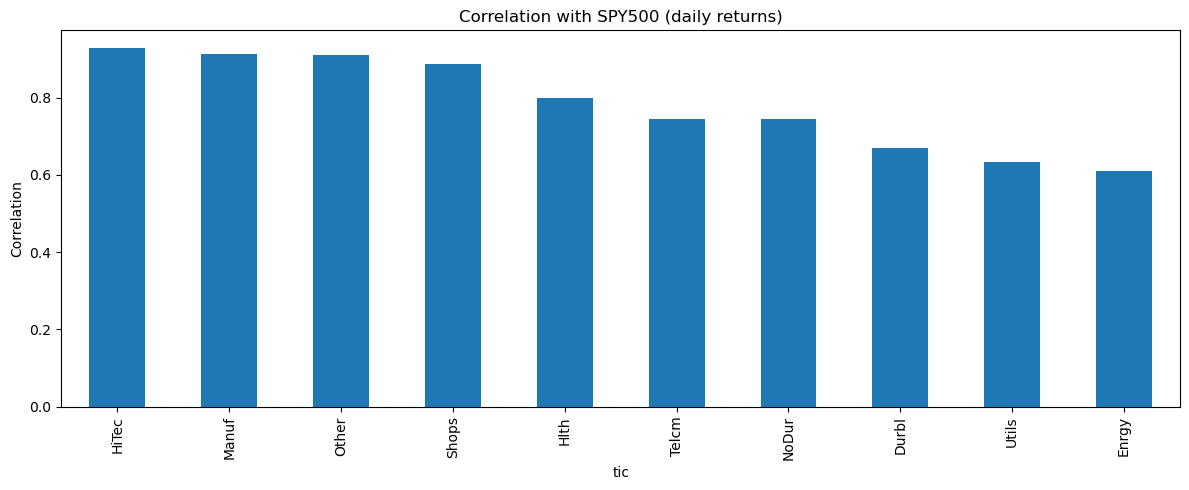

In [37]:
# Correlation of industry daily returns with SPY500 (long-format file)


industry_path = r"C:\Users\95att\Desktop\job\First_paper_QAC\Replication extension\Q-A2C-Replication- extension\Q-A2C-Replication-main\Industry\Industry_long_daily_extended.csv"

ind = pd.read_csv(industry_path)

# Expect long format: date, tic, close
required_cols = {"date", "tic", "close"}
if not required_cols.issubset(set(ind.columns)):
    raise ValueError(f"Expected columns {required_cols}, got {list(ind.columns)}")

ind["date"] = pd.to_datetime(ind["date"])
ind["close"] = pd.to_numeric(ind["close"], errors="coerce")
ind = ind.dropna(subset=["date", "tic", "close"])  # drop bad rows

# Pivot to wide: columns = industries (tic), values = close (already returns)
ind_wide = ind.pivot_table(index="date", columns="tic", values="close", aggfunc="mean").sort_index()

# If close is in percent units, convert to decimal returns
# Heuristic: if median abs > 0.5, assume percent and divide by 100
if ind_wide.abs().median().median() > 0.5:
    ind_ret = ind_wide / 100.0
else:
    ind_ret = ind_wide.copy()

# SPY returns (from earlier SPY load)
spy_ret = spy["ret"].copy()

# align dates
common_idx = ind_ret.index.intersection(spy_ret.index)
ind_ret = ind_ret.loc[common_idx]
spy_ret = spy_ret.loc[common_idx]

# drop columns with too few observations
min_obs = 30
valid_cols = [c for c in ind_ret.columns if ind_ret[c].count() >= min_obs]
ind_ret = ind_ret[valid_cols]

# correlation per industry column
corrs = ind_ret.apply(lambda s: s.corr(spy_ret))

corr_table = corrs.sort_values(ascending=False).to_frame(name="corr_with_spy")
print(corr_table)

# optional: plot
corr_table.plot(kind="bar", figsize=(12, 5), legend=False, title="Correlation with SPY500 (daily returns)")
plt.ylabel("Correlation")
plt.tight_layout()
plt.show()

## Markowitz baseline (in-sample fit, out-of-sample test)

In [39]:
# correlations

# Multiple costs